뉴스 감성분석 데이터셋 중 부정(-1), 긍정(1) 레이블 별로 가장 많이 등장한 명사들을 추출하여 워드클라우드로 만들었습니다.

# 필요 패키지 로드

In [1]:
#필요 패키지 로드
from konlpy.tag import Okt
okt = Okt()
from wordcloud import WordCloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-11-22 06:38:32.858543: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 06:38:32.862851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: 동적 오브젝트 파일을 열 수 없습니다: 그런 파일이나 디렉터리가 없습니다; LD_LIBRARY_PATH: /usr/lib/nvidia:/usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64
2022-11-22 06:38:32.862866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 데이터 전처리

In [2]:
#데이터 불러오기
data = pd.read_csv('data_1121.csv', encoding = 'utf-8')

In [3]:
#레이블별 개수 확인
data['label'].value_counts()

 0    7681
 1    2087
-1    1209
Name: label, dtype: int64

In [4]:
data.head()

,Unnamed: 0,index,icls_cnts,label
0,0,0,‘<b>경찰</b> 대혁신 TF’ 구성···<b>경찰</b>청장 ..‘이태원 핼러윈...,0
1,1,1,"""<b>경찰</b> 보고체계 마비"" 질타…이상민·행안부 별도 언급 않아 ..""이태원...",0
2,2,2,"이재명 ..“이태원 참사 <b>경찰</b> 질타한 尹, 세월호 때 박근혜 보는 듯”...",0
3,3,3,“<b>경찰</b> 업무에 대대적인 혁신이 필요하다”며 강하게 질책한 데 따른 조치...,0
4,4,4,대통령 질타한 날…<b>집회</b>현장서 게임·쇼핑한 <b>경찰</b> .. 안전<...,0


In [5]:
#필요 컬럼만 추출
data = data[['label','icls_cnts']]

In [6]:
#데이터 확인
data.head()

,label,icls_cnts
0,0,‘<b>경찰</b> 대혁신 TF’ 구성···<b>경찰</b>청장 ..‘이태원 핼러윈...
1,0,"""<b>경찰</b> 보고체계 마비"" 질타…이상민·행안부 별도 언급 않아 ..""이태원..."
2,0,"이재명 ..“이태원 참사 <b>경찰</b> 질타한 尹, 세월호 때 박근혜 보는 듯”..."
3,0,“<b>경찰</b> 업무에 대대적인 혁신이 필요하다”며 강하게 질책한 데 따른 조치...
4,0,대통령 질타한 날…<b>집회</b>현장서 게임·쇼핑한 <b>경찰</b> .. 안전<...


In [7]:
#불필요 레이블(999)를 중립 레이블(0)으로 변환
data['label'].fillna(999)
data['label'].replace(999,0,inplace = True)

In [8]:
data['label'].value_counts()

 0    7681
 1    2087
-1    1209
Name: label, dtype: int64

In [9]:
#데이터 중복 제거
data.drop_duplicates(subset = ['icls_cnts'], inplace = True)
print(len(data))

10066


<AxesSubplot: >

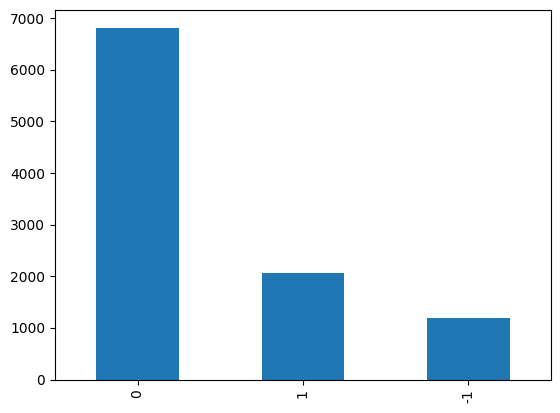

In [10]:
#차트로 레이블별 데이터 개수 확인
data['label'].value_counts().plot(kind = 'bar')

In [11]:
#데이터 레이블별 개수 확인
data['label'].value_counts()

 0    6820
 1    2061
-1    1185
Name: label, dtype: int64

In [12]:
data['icls_cnts'].dtype

dtype('O')

In [13]:
#null값, 데이터 타입 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10066 entries, 0 to 10976
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10066 non-null  int64 
 1   icls_cnts  10066 non-null  object
dtypes: int64(1), object(1)
memory usage: 235.9+ KB


In [14]:
#데이터 타입을 정수형, 문자형으로 변환
data = data.astype({'label': 'int64', 'icls_cnts': 'string'})

In [15]:
#한국어 정제 함수 만들기
import re 
def text_cleaning(text):
    hangul = re.compile('[^ㄱ-ㅣ가-힣]+')
    result = hangul.sub('',text)
    return result

In [16]:
#만든 함수 적용
data['icls_cnts'] = data['icls_cnts'].apply(text_cleaning)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10066 entries, 0 to 10976
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10066 non-null  int64 
 1   icls_cnts  10066 non-null  object
dtypes: int64(1), object(1)
memory usage: 235.9+ KB


In [18]:
#불용어 지정
stopwords = ['이아','가제','이일이','리에주','바운','메리','법등','이나','경','월','상','내','제','있다','했다','했습니다','하고','했다고','따르면','통해','됐다','위','개','이다','중','여','사','전','원','적','장','위해','및','도','는','다','의','가','이','은','한','에','하','고','을','를','인','듯','과','와','네','들','듯','지','임','게','만','게임','겜','되','음','면','했','으로','있','로','에서','것','등','해','다고','기','일','년','됐','다는','된','않','할','었','다며','던','습니다','씨','성','지만','수','았','라고','어','명','대','에게','밝혔','까지','대해','그','는데','보','권','아','간','며','해야','안','부터','돼','자','뒤','최근','서']

In [19]:
#okt 패키지를 이용하여 토크나이징 (명사만 추출)
#한글자 단어들은 배제
data['tokenized'] = data['icls_cnts'].apply(okt.nouns)
data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item in x if item not in stopwords and len(item) >1])

In [20]:
#stack에 레이블별 토큰화 결과를 저장
negative_words = np.hstack(data[data.label== -1]['tokenized'].values)
positive_words = np.hstack(data[data.label == 1]['tokenized'].values)

In [21]:
#빈출 단어 확인(부정 레이블)
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(200))

[('경찰', 2483), ('수사', 1100), ('경찰청', 748), ('경찰서', 674), ('경찰관', 606), ('사건', 404), ('혐의', 340), ('사고', 276), ('서울', 275), ('징계', 257), ('범죄', 250), ('조사', 246), ('의혹', 223), ('관련', 211), ('정보', 199), ('집회', 198), ('용산', 188), ('참사', 188), ('소속', 188), ('경위', 183), ('대응', 163), ('대한', 157), ('검찰', 155), ('신고', 150), ('특별', 149), ('경찰청장', 149), ('국민', 140), ('당시', 139), ('현장', 135), ('책임', 127), ('본부', 126), ('입건', 126), ('이태원', 122), ('안전', 122), ('부실', 120), ('위원회', 120), ('지방', 118), ('현직', 110), ('인천', 110), ('발생', 104), ('확인', 104), ('지난', 101), ('음주운전', 99), ('위반', 98), ('특수본', 97), ('과정', 97), ('감찰', 97), ('처벌', 94), ('사실', 93), ('공무원', 91), ('의원', 90), ('조치', 87), ('보고서', 87), ('직위해제', 83), ('문제', 82), ('출동', 81), ('삭제', 81), ('여성', 81), ('계장', 80), ('발견', 80), ('결과', 78), ('피해', 78), ('피해자', 78), ('논란', 77), ('상황', 76), ('기관', 75), ('광주', 75), ('지적', 74), ('근무', 74), ('폭행', 74), ('대통령', 73), ('해임', 73), ('보고', 72), ('사람', 72), ('경감', 70), ('담당', 70), ('비판', 69), ('단속', 69), ('직

In [22]:
#빈출 단어 확인(긍정 레이블)
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(100))

[('경찰', 3002), ('경찰서', 1895), ('경찰청', 839), ('범죄', 791), ('예방', 655), ('안전', 480), ('수사', 458), ('범죄예방', 430), ('신고', 421), ('경찰관', 415), ('혐의', 392), ('지역', 382), ('활동', 349), ('사고', 332), ('보이스피싱', 329), ('검거', 312), ('교통', 307), ('피해', 285), ('캠페인', 279), ('감사', 256), ('위반', 244), ('청소년', 243), ('보호', 238), ('여성', 236), ('조사', 234), ('현장', 234), ('직원', 231), ('서울', 230), ('센터', 228), ('서장', 226), ('체포', 224), ('단속', 216), ('발생', 212), ('대응', 209), ('점검', 209), ('치안', 201), ('시민', 197), ('합동', 194), ('주민', 194), ('기관', 193), ('불법', 191), ('지난', 190), ('실시', 190), ('교통사고', 187), ('순찰', 184), ('대상', 178), ('업무', 171), ('대한', 170), ('운영', 170), ('출동', 167), ('차량', 165), ('전달', 163), ('사건', 161), ('어린이', 159), ('안심', 156), ('사회', 156), ('피해자', 156), ('선정', 153), ('시설', 152), ('협약', 151), ('사기', 149), ('설치', 148), ('적발', 147), ('진행', 146), ('기자', 146), ('부산', 144), ('홍보', 144), ('광주', 142), ('금융', 139), ('관련', 138), ('이번', 138), ('아동학대', 137), ('충북', 137), ('코로나', 134), ('교육', 133), ('지원'

# 워드클라우드 생성

In [23]:
from wordcloud import WordCloud

In [24]:
new_counts = n.egative_word_count

In [25]:
temp_data_n = ' '.join(new_counts)

In [27]:
new_counts_p = positive_word_count

Text(0.5, 1.0, '부정 관련 단어')

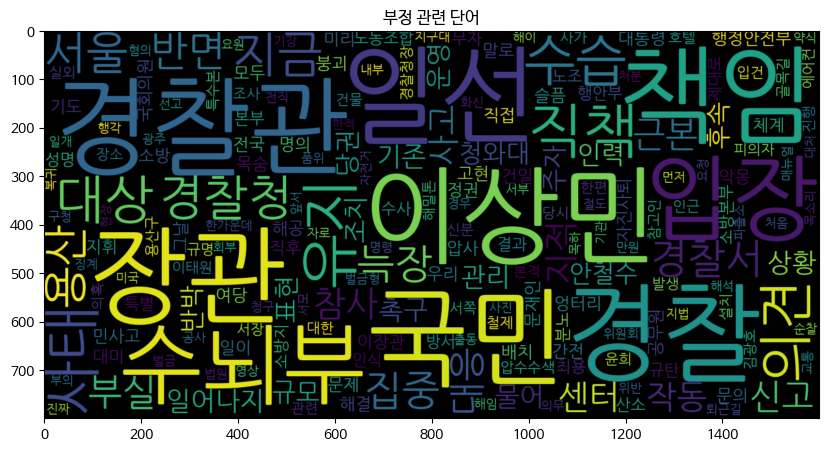

In [26]:
#부정 관련 단어 워드클라우드 확인
from wordcloud import WordCloud
import os
font = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
import matplotlib
matplotlib.rcParams['font.family']='NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus']=False
wc = WordCloud(width = 1600, height = 800, font_path = 'NanumGothic').generate(temp_data_n)
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('부정 관련 단어')

In [28]:
temp_data_p = ' '.join(new_counts_p)

Text(0.5, 1.0, '긍정 관련 단어')

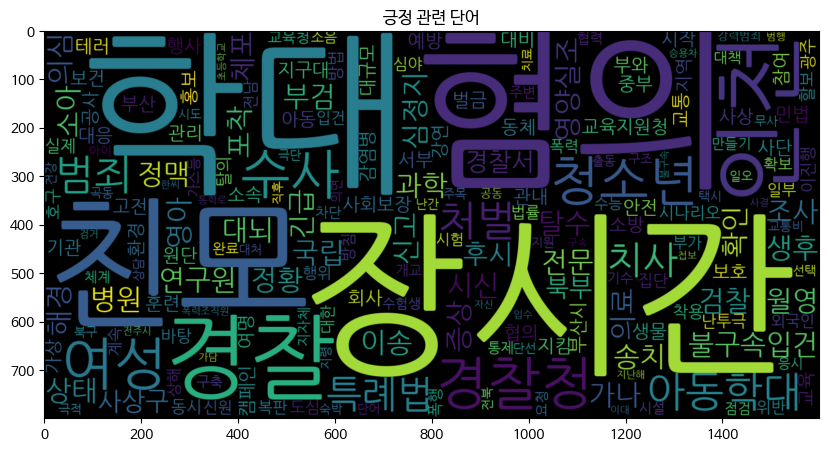

In [29]:
#긍정 관련 단어 워드클라우드 확인
from wordcloud import WordCloud
import os
font = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
import matplotlib
matplotlib.rcParams['font.family']='NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus']=False
wc = WordCloud(width = 1600, height = 800, font_path = 'NanumGothic').generate(temp_data_p)
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('긍정 관련 단어')